In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import keras
from keras.layers import Input, Dense, Conv2D, AveragePooling2D, Activation, GlobalAveragePooling2D, UpSampling2D, Lambda
from keras.layers.core import Dropout, Reshape
from keras.layers.merge import Concatenate
from keras.layers.normalization import BatchNormalization
from keras.initializers import Initializer
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from PIL import Image
import scipy.misc
import matplotlib.pyplot as plt
from scipy.misc import imsave
import pydot
import graphviz
from keras.utils import plot_model
import glob
import bcolz

Using TensorFlow backend.


In [2]:
#Open dataset
x_all = bcolz.open('dataset/x_train.bc')[:]
y_all = bcolz.open('dataset/y_train_encoded.bc')[:]

num_elements = x_all.shape[1] * x_all.shape[2]

#Split into train, validation, and test set
x_train = x_all[:450]
y_train = y_all[:450]
y_train = np.reshape(y_train,(len(y_train),num_elements))
y_train = np.expand_dims(y_train,axis=2)

x_validation = x_all[450:625]
y_validation = y_all[450:625]
y_validation = np.reshape(y_validation,(len(y_validation),num_elements))
y_validation = np.expand_dims(y_validation,axis=2)

x_test = x_all[625:]
y_test = y_all[625:]
y_test = np.reshape(y_test,(len(y_test),num_elements))
y_test = np.expand_dims(y_test,axis=2)

In [3]:
#Similar to densenet implementation, we define these blocks/layers
#The only difference is that now we want to store_x_ to be concatenated
#into the upsampling part of the network

#Since there are downsampling and upsampling part, we also need
# to define a new block, transition_layers_upsample

def dense_block(x,num_layers_per_block_,growth_rate):
    store_x_ = []
    for i in range(num_layers_per_block_):
        x_ = BatchNormalization()(x)
        x_ = Activation('relu')(x_)
        x_ = Conv2D(growth_rate,(3,3),padding='same',
                    kernel_initializer='he_normal',
                    kernel_regularizer=l2(0.0001))(x_)
        x_ = Dropout(0.2)(x_)
        store_x_.append(x_)
        x = Concatenate()([x,x_])
    return x, store_x_

def transition_downsample_layers(x):
    updated_num_filters = int(x.get_shape().as_list()[-1])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(updated_num_filters,(1,1),padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=l2(0.0001))(x)
    x = AveragePooling2D()(x)
    x = Dropout(0.2)(x)
    return x

def transition_upsample_layers(store_x_):
    x = Concatenate()(store_x_)
    x = UpSampling2D()(x)
    return x

In [4]:
#Define model parameters
num_dense_blocks = 6
growth_rate = 16
number_filters = 48
num_layers_per_block = [4,5,7,10,12,15] #see in paper

In [5]:
#Let's define the model
inp = Input((256, 384, 3))
x = Conv2D(number_filters,(3,3),padding='same',
           kernel_initializer='he_normal',
           kernel_regularizer=l2(0.0001))(inp)

#Downsample
skip_connection = []
for i in range(len(num_layers_per_block)):
    x,store_x_ = dense_block(x,num_layers_per_block[i],growth_rate)
    skip_connection.append(x)
    x = transition_downsample_layers(x)
    
#Upsample
skip_connection_ = (skip_connection[:-1])[::-1]
num_layers_per_block_ = (num_layers_per_block[:-1])[::-1]
for i in range(len(num_layers_per_block_)):
    x = transition_upsample_layers(store_x_)
    x = Concatenate()([x,skip_connection_[i]])
    x,store_x_ = dense_block(x,num_layers_per_block_[i],growth_rate)

x = Conv2D(32,(1,1),padding='same',
           kernel_initializer='he_normal',
           kernel_regularizer=l2(0.0001))(x)
x = Reshape((-1, 32))(x)
x = Activation('softmax')(x)

In [6]:
model = Model(inp, x)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(0.0001),
              metrics=["accuracy"])
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_acc', 
                                            patience=45, 
                                            verbose=1, mode='auto')
plot_model(model, to_file='images/model_256by384.png')
#model.summary()

In [7]:
model.load_weights('tiramisu256by384_200epochs_weights.h5')

In [8]:
#ONLY RUN THIS FOR TRAINING
#model.fit(x_train, y_train, batch_size=3, epochs=100, shuffle=True,
#          validation_data=(x_validation, y_validation),
#          callbacks=[earlyStopping])

#model.save('tiramisu256by384_200epochs_model_weights.h5')
#model.save_weights('tiramisu256by384_200epochs_weights.h5')

In [9]:
evaluation = model.evaluate(x_test,y_test, batch_size=3, verbose=1)
print('Loss: %.2f Accuracy: %.2f%%' % (evaluation[0], evaluation[1]*100.0))

76/76 [==============================] - 11s    
Loss: 0.32 Accuracy: 92.79%


# Let's see some comparisons

In [10]:
#First we need some functions that map our output to the color map
def get_color(file):
    splitted=[]
    for i in open(file):
        colors = i.strip().split('\t')
        for j in colors[0]:
            line = colors[0].split(' ')
        line = list(map(int, line))
        splitted.append(line)
    return splitted

def code_to_color(mat,code_color):
    mat_reshaped = mat.reshape(x_all.shape[1],x_all.shape[2])
    #We want the output to be 3 channels
    color_map = np.zeros((x_all.shape[1],x_all.shape[2],3), 'uint8')
    for i in range(x_all.shape[1]): 
        for j in range(x_all.shape[2]):
            color = code_color[mat_reshaped[i,j]]
            color_map[i,j] = color
    return color_map

In [11]:
#Now use the functions to link the code numbers and colors
color = get_color('label_colors.txt')
code_color = {i:j for i,j in enumerate(color)}

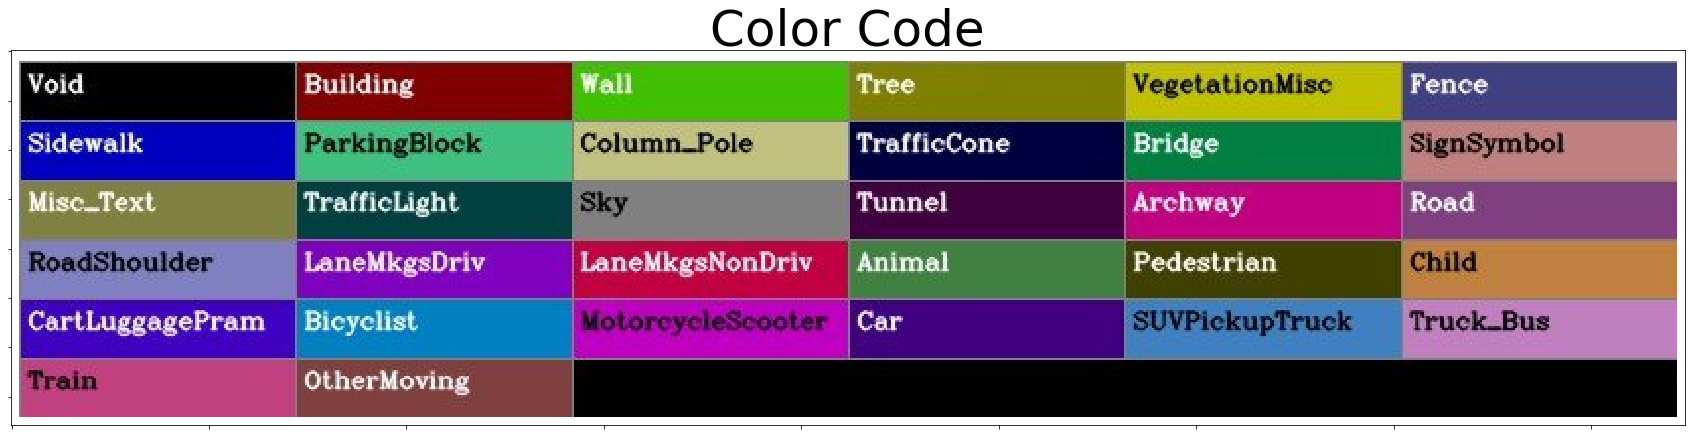

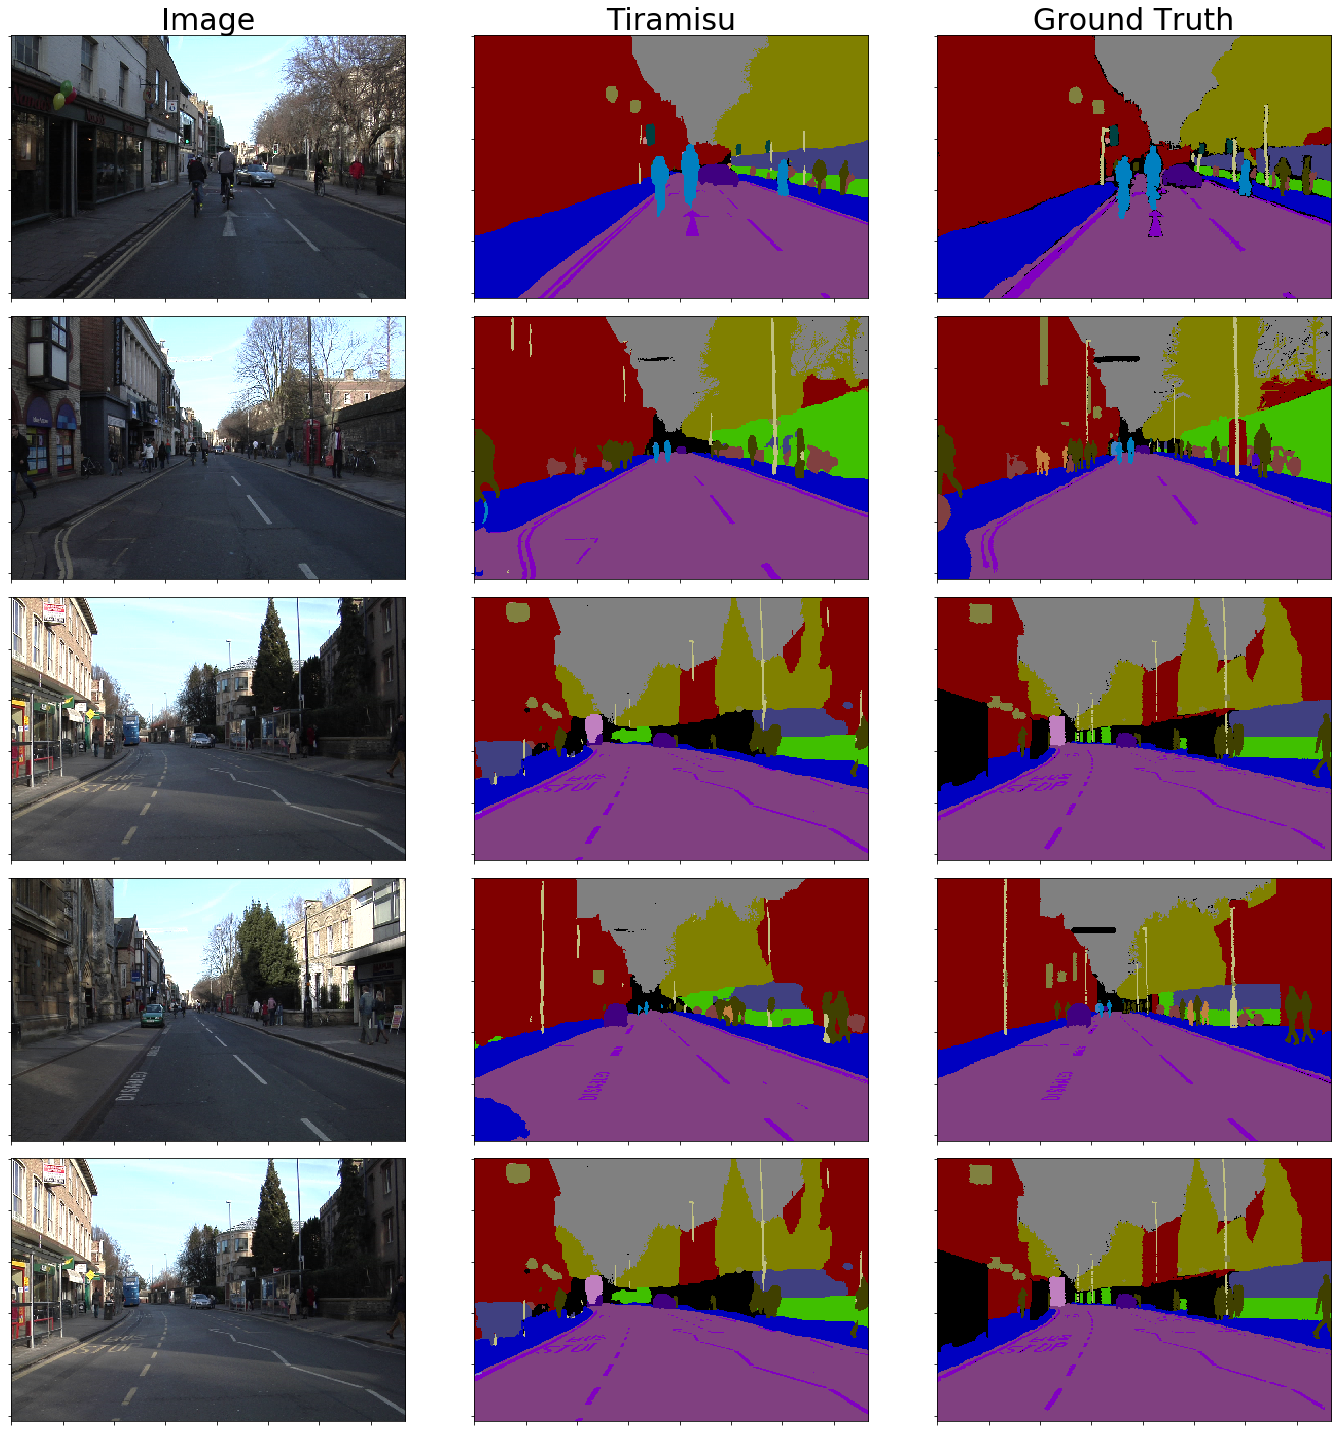

In [12]:
#Show CamVid color code
cc = Image.open('images/color_code.png')
fig,axis = plt.subplots(nrows=1, ncols=1, figsize=(30,30))
axis.set_title('Color Code',fontsize=50)
axis.imshow(cc);
axis.set_yticklabels([]);
axis.set_xticklabels([]);

#Show comparisons
num_pred = 5
columns = ['{}'.format(col) for col in ['Image', 'Tiramisu', 'Ground Truth']]
fig,axis = plt.subplots(nrows=num_pred, ncols=3, figsize=(20,20))
for ax,col in zip(axis[0], columns):
    ax.set_title(col,fontsize=30)
    
for i in range(num_pred):
    random_index = np.random.randint(0,76)
    img = np.expand_dims(x_test[random_index],axis=0)
    predictions = model.predict(img)
    predictions_arg = np.argmax(predictions, axis=-1)
    color_coded = code_to_color(predictions_arg[0], code_color)
    ground_truth = code_to_color(y_test[random_index], code_color);

    axis[i,0].imshow(x_test[random_index])
    axis[i,1].imshow(color_coded)
    axis[i,2].imshow(ground_truth)
    
    axis[i,0].set_yticklabels([])
    axis[i,0].set_xticklabels([])
    axis[i,1].set_yticklabels([])
    axis[i,1].set_xticklabels([])
    axis[i,2].set_yticklabels([])
    axis[i,2].set_xticklabels([])

plt.tight_layout()
plt.show()